<div style="direction:rtl; font-size:12px">به نام خدا</div>
<div style="direction:rtl; font-size:12px">گروه 8 : آرمین افتخاری - محمد سلیمان بهزاد - محمدرضا پوررضا - رضا برزگر طرقبه - سبحان مرادیان دقیق</div>
<div style="direction:rtl"> در این بخش با استفاده از الگوریتم KNN که یک کلاسیفایر رایج در مبحث ماشین لرنینگ می باشد استفاده کرده ایم. با استفاده از این الگوریتم می توانیم داده های train خود را کلاستر بندی کنیم. سپس مدلی ترین کنیم و با استفاده از آن به ازای هر داده تست، یک همسایگی 10 تایی از شبیه ترین داده ها را پیدا می کنیم. توضیحات بیشتر و جزئی تر در داکیومنت و خلال کد ها داده شده است.</div>

### Implementation of KNN

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors , KNeighborsClassifier
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

### Reading the dataset which was preprocessed

In [2]:
book_ratings = pd.read_csv('preprocessed_ratings.csv')

In [3]:
book_ratings.head()

,User_ID,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Location,Age
0,53,451,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"strafford, missouri, usa",34.0
1,53,280,0,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown","strafford, missouri, usa",34.0
2,53,647,0,The Da Vinci Code,Dan Brown,2003,Doubleday,"strafford, missouri, usa",34.0
3,53,2028,0,Wild Animus,Rich Shapero,2004,Too Far,"strafford, missouri, usa",34.0
4,53,241,0,Four To Score (A Stephanie Plum Novel),Janet Evanovich,1999,St. Martin's Paperbacks,"strafford, missouri, usa",34.0


### Filtering the book attrs

In [4]:
books = book_ratings.filter(['Book_Title' , 'Book_Author', 'Year_Of_Publication','Publisher', 'Book_Rating']).copy()
books = books.drop_duplicates(subset='Book_Title', keep='first')

### Loading the similarity matrix 

In [5]:
 with open('sim_matrix', 'rb') as fp:
    sim_matrix = pickle.load(fp)

### Finding the best amount of k using Elbow 

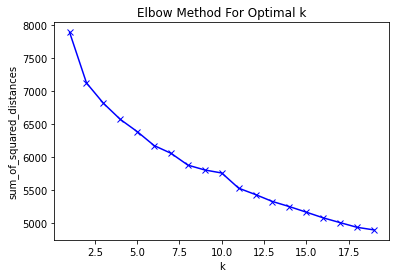

In [19]:
sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k, n_init=20)
    km = km.fit(sim_matrix)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### So according to the plot, decide to take the k=7

In [7]:
true_k =7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=50)
model.fit(sim_matrix)
labels=model.labels_
books['label'] = labels

### Now we have a Supervised dataset

### Splite it into train and test

In [9]:
def splitter(dataset):
    
    dataset = dataset.sort_values('Book_Rating', ascending=False)

    test_range = round(len(dataset) * 0.2)
    test_data = books.iloc[:test_range]
    train_data = books.iloc[test_range:]
    
    return train_data, test_data

In [10]:
train_data , test_data = splitter(books)
test_data = test_data.reset_index(drop=True)

In [11]:
len(train_data), len(test_data)

(1530, 383)

In [12]:
train_X = train_data.drop(['label'],axis=1)
train_Y = train_data['label']

test_X = test_data.drop(['label'],axis=1)
test_Y = test_data['label']

### Use a LabelEncoder 

In [13]:
encoder = LabelEncoder()
for col in train_X.columns:
    train_X[col] = encoder.fit_transform(train_X[col])
    
for col in test_X.columns :
    test_X[col] = encoder.fit_transform(test_X[col])

### And now try to make a KNN model for our train dataset and after that make a prediction

In [14]:
knn = KNeighborsClassifier(n_neighbors=20, algorithm='auto', weights='distance')
knn.fit(train_X, train_Y)
predict = knn.predict(test_X)

### Here we go its time to use our recommendation system 

In [15]:
def recommender(book_title):
    book_index = test_data[test_data["Book_Title"] == book_title].index.tolist()[0]
    label = predict[book_index]
    similar_items = train_data[train_data['label'] == label].Book_Title.iloc[:10,]
    return similar_items

### Top 10 recommended books for the input one

In [16]:
recommender('The Lovely Bones: A Novel')

457                        Daisy Fay and the Miracle Man
458                                         Cold Blooded
464                                   Nights in Rodanthe
465                                  The Grapes of Wrath
466                                       Kiss the Girls
467              Seven Habits Of Highly Effective People
468                                      Mother of Pearl
470    Valley of the Horses (Auel, Jean M. , Earth's ...
471    Confessions of a Shopaholic (Summer Display Op...
473                                      Cold Sassy Tree
Name: Book_Title, dtype: object

### Finaly, here is the accuracy for our recommendation :))

In [17]:
accuracy_score(test_Y, predict)

0.825065274151436

### Yohaa